## Notebook for loan dataset

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Import data

In [215]:
data = pd.read_csv("data/loan_data/loan-10k.lrn.csv", sep=",")
df_final_test  = pd.read_csv("data/loan_data/loan-10k.tes.csv")

In [216]:
data.head()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C


In [194]:
df_final_test.head()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3582,10000.0,10000.0,10000.0,36 months,9.93,322.35,< 1 year,MORTGAGE,130000.0,...,Cash,N,9,2017,8,2006,2,2019,2,2019
1,60498,20000.0,20000.0,20000.0,60 months,13.67,461.96,10+ years,MORTGAGE,75500.0,...,Cash,N,3,2016,3,2002,0,2018,2,2019
2,53227,15000.0,15000.0,15000.0,36 months,11.80,496.79,< 1 year,RENT,38000.0,...,Cash,N,11,2018,9,2004,2,2019,2,2019
3,21333,12500.0,12500.0,12500.0,36 months,15.31,435.22,10+ years,MORTGAGE,65000.0,...,Cash,N,4,2013,10,1996,4,2016,2,2018
4,3885,19000.0,19000.0,19000.0,60 months,27.88,590.21,6 years,MORTGAGE,38000.0,...,Cash,N,10,2015,1,2001,4,2016,2,2019


In [156]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(data)

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,Not Verified,Current,n,debt_consolidation,IL,25.33,0.0,715.0,719.0,1.0,29.0,0.0,18833.0,16.6,61.0,w,9950.34,9950.34,3092.350000,3092.35,2549.66,542.69,0.0,0.00,0.0000,387.17,724.0,720.0,0.0,1.0,Individual,0.0,0.0,518741.0,116200.0,12.0,17888.0,89567.0,17.4,0.0,0.0,191.0,216.0,3.0,3.0,1.0,3.0,3.0,1.0,11.0,11.0,12.0,21.0,32.0,15.0,28.0,11.0,29.0,0.0,0.0,0.0,3.0,95.8,0.0,0.0,0.0,585675.0,379822.0,108400.0,325925.0,N,Cash,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,Source Verified,Current,n,debt_consolidation,OK,36.72,0.0,670.0,674.0,1.0,22.0,0.0,33158.0,61.3,59.0,f,15342.65,15308.66,36524.120000,36443.20,18507.35,18016.77,0.0,0.00,0.0000,915.57,634.0,630.0,0.0,1.0,Individual,0.0,0.0,252600.0,54100.0,4.0,12630.0,4870.0,73.8,0.0,0.0,172.0,373.0,4.0,4.0,5.0,31.0,4.0,0.0,4.0,12.0,5.0,7.0,28.0,18.0,26.0,12.0,22.0,0.0,0.0,0.0,2.0,98.3,40.0,0.0,0.0,296367.0,105854.0,18600.0,84967.0,N,Cash,N,10,2015,9,1984,2,2019,2,2019,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,27371,11000.0,11000.0,11000.0,60 months,16.29,269.20,1 year,RENT,38500.0,Source Verified,Charged Off,n,medical,CA,14.09,0.0,725.0,729.0,0.0,13.0,0.0,4261.0,15.1,17.0,w,0.00,0.00,5496.490000,5496.49,2274.94,2352.72,0.0,868.83,156.3894,269.20,499.0,0.0,0.0,1.0,Individual,0.0,0.0,40974.0,28200.0,6.0,3152.0,9905.0,1.9,0.0,0.0,96.0,97.0,10.0,10.0,0.0,10.0,13.0,0.0,2.0,4.0,3.0,3.0,4.0,10.0,13.0,4.0,13.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,68787.0,40974.0,10100.0,40587.0,N,Cash,N,9,2014,8,2006,3,2016,10,2016,D
9999,8729,30000.0,30000.0,29900.0,36 months,12.29,1000.59,10+ years,MORTGAGE,110000.0,Verified,Fully Paid,n,credit_card,OH,28.08,0.0,710.0,714.0,0.0,13.0,0.0,38590.0,54.5,27.0,f,0.00,0.00,36000.746708,35880.74,30000.00,6000.75,0.0,0.00,0.0000,1000.58,739.0,735.0,0.0,1.0,Individual,0.0,0.0,265582.0,70800.0,3.0,22132.0,19048.0,65.9,0.0,0.0,150.0,404.0,56.0,3.0,6.0,92.0,4.0,0.0,3.0,5.0,5.0,6.0,4.0,9.0,15.0,5.0,13.0,0.0,0.0,0.0,3.0,100.0,40.0,0.0,0.0,301067.0,94278.0,55800.0,22195.0,N,Cash,N,9,2015,1,1982,9,2018,9,2018,C


### Data exploration

In [157]:
data_index = data["ID"]

# set ID column as index
data.set_index("ID", inplace=True)

In [170]:
# encode target variable
label_encoder = LabelEncoder()
data["grade"] = label_encoder.fit_transform(data["grade"])

# encode columns with dtype object/string as dummy variables
# data_encoded = pd.get_dummies(data, drop_first=True)

categorical_data = data.select_dtypes(include=["object"])

oh_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="first")
categorical_data_encoded = oh_encoder.fit_transform(categorical_data)
categorical_data_encoded = pd.DataFrame(categorical_data_encoded)
categorical_data_encoded["ID"] = data_index
categorical_data_encoded.set_index("ID", inplace=True)

numerical_data = data.select_dtypes(include=["number"])

data_encoded = pd.concat([numerical_data, categorical_data_encoded], axis=1)

data_encoded = data_encoded.rename(str,axis="columns")

In [66]:
# Todo: Plot distributions, outliers, class distribution

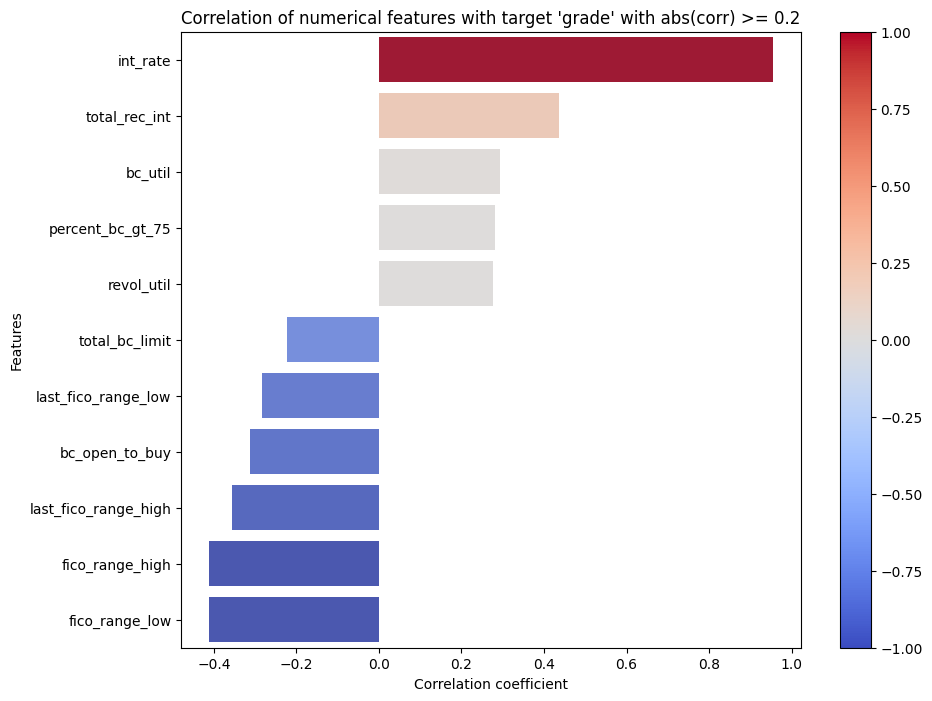

In [67]:
numerical_data = data_encoded.select_dtypes(include=["number"])

# Compute correlation matrix & filter for columns greater than 0.2
corr_matrix = numerical_data.corr()["grade"].drop("grade")
corr_matrix_filtered = corr_matrix[corr_matrix.abs() >= 0.2]

# Sort by absolute correlation value
corr_matrix_sorted = corr_matrix_filtered.sort_values(ascending=False)

plt.figure(figsize=(10, 8))

norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

ax = sns.barplot(x=corr_matrix_sorted.values, y=corr_matrix_sorted.index, palette="coolwarm", hue=corr_matrix_sorted.values)
ax.set_title("Correlation of numerical features with target 'grade' with abs(corr) >= 0.2")
ax.set_xlabel("Correlation coefficient")
ax.set_ylabel("Features")
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)

plt.show()

### Train/Test Split

In [176]:
X = data_encoded.drop("grade", axis=1)
y = data_encoded["grade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
X_train

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,79,80,81,82,83,84,85,86,87,88
ID,,,,,,,,,,,,,,,,,,,,,
85649,12000.0,12000.0,12000.0,11.99,398.52,35000.0,32.96,0.0,685.0,689.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96803,10000.0,10000.0,10000.0,13.65,340.08,49000.0,9.11,0.0,680.0,684.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10455,1000.0,1000.0,1000.0,26.31,40.46,23000.0,0.00,2.0,675.0,679.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38241,10500.0,10500.0,10500.0,14.99,249.74,115000.0,25.64,1.0,695.0,699.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45513,30000.0,30000.0,30000.0,9.17,956.37,150000.0,15.54,1.0,720.0,724.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57011,23800.0,23800.0,23800.0,11.99,529.30,64000.0,22.85,0.0,685.0,689.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41502,5375.0,5375.0,5375.0,14.46,184.91,40500.0,29.96,1.0,670.0,674.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
89665,10000.0,10000.0,10000.0,22.20,277.33,65500.0,14.47,0.0,685.0,689.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data preprocessing

In [16]:
# Check for missing values

# Check if there are any missing values
has_null = data_encoded.isna().values.any()

# Print total number of missing values
total_null = data_encoded.isna().sum().sum()

print(f"The dataset has null values: {has_null}")
print(f"The dataset has {total_null} null values")

The dataset has null values: False
The dataset has 0 null values


In [17]:
# Todo
df_final_test.isna().sum().sum()

np.int64(0)

In [ ]:
# standard_scaler = StandardScaler()
# X_train_scaled = standard_scaler.fit_transform(X_train)
# X_test_scaled = standard_scaler.transform(X_test)

## Robust Scaler

min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

## Classification models

Todo: Feature Selection KNN

1. KNN
2. Random Forest
3. MLP TODO

### KNN Classification

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
y_pred_knn = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn, normalize=True)
f1 = f1_score(y_test, y_pred_knn, average="micro")

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.29
F1 Score: 0.29


In [28]:
knn_model_scaled = KNeighborsClassifier()
knn_model_scaled.fit(X_train_scaled, y_train)

y_pred_knn = knn_model_scaled.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred_knn, average="micro")

accuracy = accuracy_score(y_test, y_pred_knn, normalize=True)
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.36
F1 Score: 0.36


### Random Forest Classification

In [29]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
f1 = f1_score(y_test, y_pred, average="micro")

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.79
F1 Score: 0.79


### Hyperparamter Tuning Random Forest

In [20]:
param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "max_features": ['sqrt', 0.2, 0.5],
    "max_depth": [10, 20, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "bootstrap": [True, False],
    "class_weight": [None, 'balanced']
}

grid_search_cv = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf, 
    scoring="accuracy",
    cv=3,
    verbose=3,
    n_jobs=-1)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [10, 20, 50],
                         'max_features': ['sqrt', 0.2, 0.5],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=3)

In [31]:
print("Best Hyperparameters:", grid_search_cv.best_params_)
print("Best Accuracy:", grid_search_cv.best_score_)

best_rf = grid_search_cv.best_estimator_

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
f1 = f1_score(y_test, y_pred, average="micro")

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

NameError: name 'grid_search_cv' is not defined

In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_features": ['sqrt', 0.2],
    "max_depth": [10, 20],
    "min_samples_leaf": [5, 10],
    "class_weight": ['balanced']
}

grid_search_cv = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf, 
    scoring="accuracy",
    cv=5,
    verbose=3,
    n_jobs=-1)

grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [10, 20],
                         'max_features': ['sqrt', 0.2],
                         'min_samples_leaf': [5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=4)

In [120]:
print("Best Hyperparameters:", grid_search_cv.best_params_)
print("Best Accuracy:", grid_search_cv.best_score_)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 0.2, 'min_samples_leaf': 5, 'n_estimators': 100}
Best Accuracy: 0.901


In [127]:
best_rf = grid_search_cv.best_estimator_

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


In [ ]:

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['sqrt', 'log2', 0.2, 0.5],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}


# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=3,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV model
random_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20, 'class_weight': None, 'bootstrap': False}
Best Accuracy: 0.978125


In [131]:
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


### Initial Kaggle Submission

In [180]:
rf_model_kaggle = RandomForestClassifier(
    n_estimators=500, 
    min_samples_split=2, 
    max_features=0.5,
    max_depth=20,
    class_weight=None,
    bootstrap=False,
    random_state=42)
rf_model_kaggle.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, max_features=0.5,
                       n_estimators=500, random_state=42)

In [181]:
y_pred = rf_model_kaggle.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=True)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.98
F1 score: 0.95


In [195]:
data_index = df_final_test["ID"]

# set ID column as index
df_final_test.set_index("ID", inplace=True)

# encode columns with dtype object/string as dummy variables
#final_test_encoded = pd.get_dummies(df_final_test, drop_first=True)

categorical_data = df_final_test.select_dtypes(include=["object"])

final_test_categorical_encoded = oh_encoder.transform(categorical_data)
final_test_categorical_encoded = pd.DataFrame(final_test_categorical_encoded)
final_test_categorical_encoded["ID"] = data_index
final_test_categorical_encoded.set_index("ID", inplace=True)

test_numerical_data = df_final_test.select_dtypes(include=["number"])

test_data_encoded = pd.concat([test_numerical_data, final_test_categorical_encoded], axis=1)

test_data_encoded = test_data_encoded.rename(str,axis="columns")

c:\Users\ckand\Documents\TU Wien\Machine Learning\Exercise 0\MachineLearningCourse\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [197]:
y_pred_kaggle = rf_model_kaggle.predict(test_data_encoded)

In [222]:
label_encoder.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [223]:
data_index_final = df_final_test["ID"]

output_file = pd.DataFrame({"ID": data_index_final, "grade": y_pred_kaggle})
output_file["grade"] = output_file["grade"].replace({0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"})
output_file

,ID,grade
0,3582,B
1,60498,C
2,53227,B
3,21333,C
4,3885,F
...,...,...
9995,89555,C
9996,88135,B
9997,51888,C
9998,51380,D


In [225]:
output_file.to_csv("loan_test.csv", index=False)